In [1]:
# Importing Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")

# Neural Network library
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Technials Analysis Library
os.chdir("../technicals")
import technicals

# Market Data Connection
os.chdir("../marketdata")
import alpaca

In [2]:
# Set market data date range 
from datetime import date, datetime, timedelta

end_date  = datetime.now()
start_date  = (end_date - timedelta(days=1000))

start_date = start_date.strftime('%Y-%m-%d')
end_date = end_date.strftime('%Y-%m-%d')

print(f"Start date : {start_date}")
print(f"End date : {end_date}")

Start date : 2018-10-16
End date : 2021-07-12


In [3]:
# Load the dataset
test_tickers = ["ADSK"]
ohlcv_df = alpaca.ohlcv(test_tickers, start_date=start_date, end_date=end_date)
tech_ind = technicals.TechnicalAnalysis(ohlcv_df)

df = tech_ind.get_all_technicals(test_tickers[0])
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
df.head()

C:\Users\illya\anaconda3\envs\cu_proj_2\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,close,rsi,williams,mfi,stoch_k,macd,ma_10,ma_50,ma_200,ema_7,ema_14,ema_21,highlow,closeopen,bb_high,bb_low,pvt
time,,,,,,,,,,,,,,,,,
2018-10-16 00:00:00-04:00,141.42,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,141.420000,141.420000,141.420000,5.1800,3.6700,0.0,0.0,0.000000
2018-10-17 00:00:00-04:00,141.82,100.000000,0.0,0.0,0.0,0.008974,0.0,0.0,0.0,141.648571,141.634286,141.629524,3.4000,0.6400,0.0,0.0,0.000000
2018-10-18 00:00:00-04:00,137.28,55.226824,0.0,0.0,0.0,-0.129350,0.0,0.0,0.0,139.759459,139.970934,140.039517,5.6900,-3.4800,0.0,0.0,-61068.183852
2018-10-19 00:00:00-04:00,133.18,38.533373,0.0,0.0,0.0,-0.337122,0.0,0.0,0.0,137.353257,137.893396,138.072265,7.3299,-5.6299,0.0,0.0,-28725.462394
2018-10-22 00:00:00-04:00,135.64,48.534072,0.0,0.0,0.0,-0.345035,0.0,0.0,0.0,136.791677,137.305488,137.488969,5.8600,1.7100,0.0,0.0,115237.903532


In [4]:
# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()

In [5]:
close_scaler.fit(df[['close']])

RobustScaler()

In [6]:
scaler = RobustScaler()

In [7]:
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [8]:
# Helper Functions
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)
  
    
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass
          
    
def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))

In [9]:
# How many periods looking back to learn
n_per_in  = 100

# How many periods to predict
n_per_out = 14

# Features 
n_features = df.shape[1]

# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [10]:
## Creating the NN

# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=1, 
            n_nodes=30, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Fitting and Training
res = model.fit(X, y, epochs=50, batch_size=128, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 90)           38880     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 30)           14520     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dense (Dense)                (None, 14)                854       
Total params: 76,094
Trainable params: 76,094
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 [==============================] - 20s 527ms/step - loss: 0.2749 - accuracy: 0.0762 - val_loss: 0.5099 - val_accuracy: 0.0862
Epoch 2/50
5/5 [==============================] - 1s 207ms/step - loss: 0.1348 - accuracy: 0.0559 - val_loss:

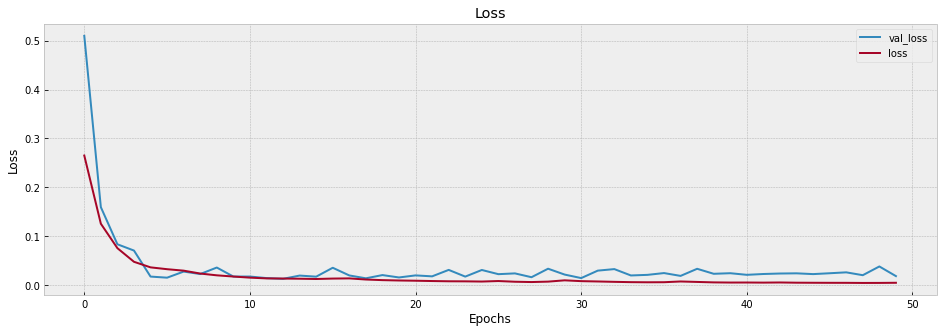

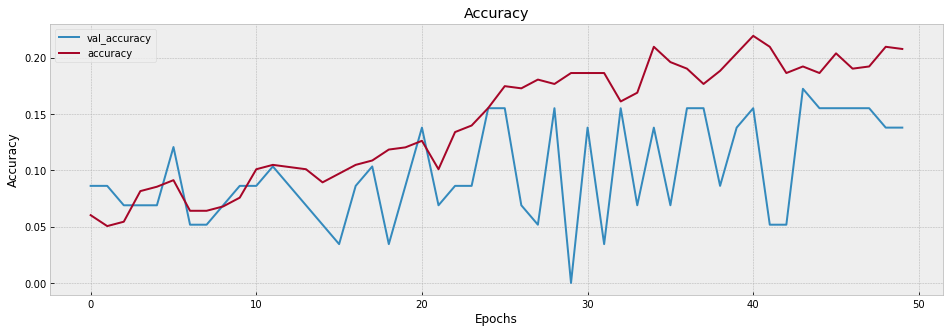

In [11]:
visualize_training_results(res)

RMSE: 6.299946407577504


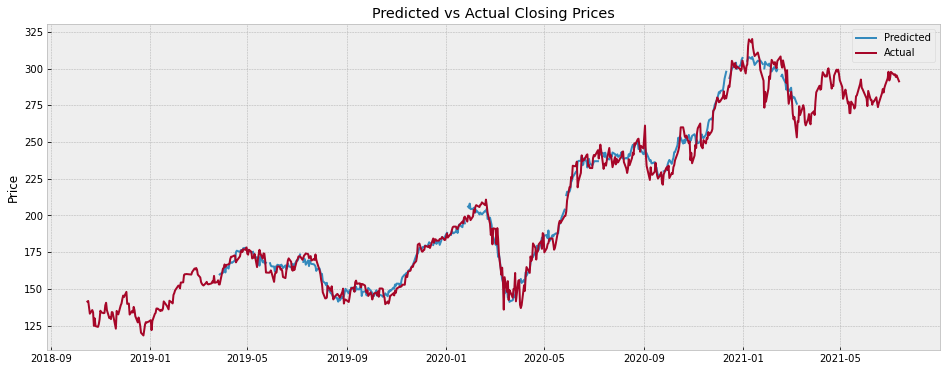

In [12]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.show()

In [13]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

In [14]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]].tail(pers)), 
                      index=df.close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))

In [ ]:
# Printing the predicted prices
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()

In [ ]:
# Set market data date range 
from datetime import date, datetime, timedelta

pred_end_date  = datetime.now()
pred_start_date  = (pred_end_date - timedelta(days=14))

pred_start_date = pred_start_date.strftime('%Y-%m-%d')
pred_end_date = pred_end_date.strftime('%Y-%m-%d')

print(f"Start date : {pred_start_date}")
print(f"End date : {pred_end_date}")

In [ ]:
# Load the dataset
pred_tickers = ["ADSK"]
pred_ohlcv_df = alpaca.ohlcv(pred_tickers, start_date=pred_start_date, end_date=pred_end_date)
pred_tech_ind = technicals.TechnicalAnalysis(pred_ohlcv_df)

pred_df = pred_tech_ind.get_all_technicals(pred_tickers[0])
pred_df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
pred_df.head()

In [ ]:
# Scale fitting the close prices separately for inverse_transformations purposes later
pred_close_scaler = RobustScaler()

In [ ]:
pred_close_scaler.fit(pred_df[['close']])

In [ ]:
pred_scaler = RobustScaler()

In [ ]:
pred_df = pd.DataFrame(pred_scaler.fit_transform(pred_df), columns=pred_df.columns, index=pred_df.index)

In [ ]:
pred_df.head()

In [ ]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

In [ ]:
# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

In [ ]:
# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]].tail(pers)), 
                      index=df.close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()